In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

Preprocessing Data...
Shape of Credit Card Inof Data: (984, 5)
Shape of Transactions Data: (294588, 5)

Preview of Merged Data:
        credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat     city state  zipcode  credit_card_limit  
0 -80.174132  40.267370  Houston    PA    15342              20000  
1 -80.194240  40.180114  Houston    PA    15342              20000  
2 -80.211033  40.313004  Houston    PA    15342              20000  
3 -80.174138  40.290895  Houston    PA    15342              20000  
4 -80.238720  40.166719  Houston    PA    15342              20000  

Shape of Merged Data: (294588,

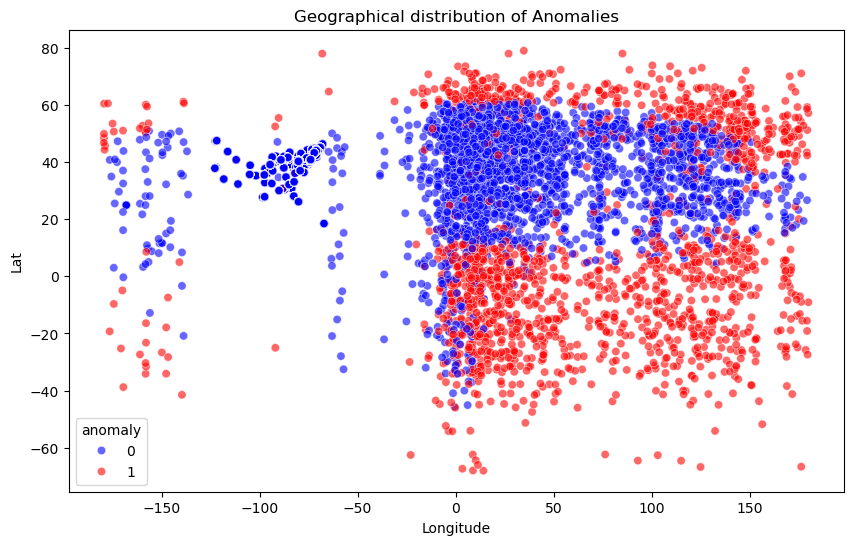

In [9]:
class FraudDetection:
    def __init__(self, cc_info_path, transactions_path):
        self.cc_info_path = 'cc_info.csv'
        self.transactions_path = 'transactions.csv'
        self.cc_info = pd.read_csv(cc_info_path)
        self.transactions = pd.read_csv(transactions_path)
        self.data = None
        self.model = None

    def preprocess_data(self):
        self.cc_info = pd.read_csv('cc_info.csv')
        self.transactions = pd.read_csv('transactions.csv')
        print("Shape of Credit Card Inof Data:", self.cc_info.shape)
        print("Shape of Transactions Data:", self.transactions.shape)

        # Merge the credit card information and transaction data
        self.data = pd.merge(self.transactions, self.cc_info, on='credit_card', how='inner')

        print("\nPreview of Merged Data:")
        print(self.data.head())
        print("\nShape of Merged Data:", self.data.shape)
        print("\nChecking for missing values before dropping:")
        print(self.data.isnull().sum())
        self.data.dropna(inplace=True)
        print("\nShape after dropping missing values:", self.data.shape)

        if self.data.empty:
            raise ValueError("The dataset is empty after preprocessing. Please check the input data and merging process.")
        
        self.data['transaction_percentage'] = self.data['transaction_dollar_amount']/self.data['credit_card_limit']
        print('\nPreview of Data after Feature Engineering:')
        print(self.data[['transaction_dollar_amount', 'credit_card_limit', 'transaction_percentage']].head())
        features = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit', 'transaction_percentage']  
        self.data = self.data[features]
        print('\n Preview of Selected Features:')
        print(self.data.head())

        scaler = StandardScaler()
        self.data_scaled = scaler.fit_transform(self.data)
        print("\nData Scaling completed successfully.")

    def build_autoencoder(self, input_dim):
        self.model = Sequential()
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(input_dim, activation='linear'))
        self.model.compile(optimizer='adam', loss='mse')

    def train_model(self, epochs=20, batch_size=32):
        X_train, X_val = train_test_split(self.data_scaled, test_size=0.2, random_state=42)
        self.model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, X_val), verbose=1)

    def detect_anomalies(self, threshold=0.01):
        reconstructions = self.model.predict(self.data_scaled)
        reconstructions_error = np.mean(np.square(self.data_scaled - reconstructions), axis=1)
        anomaly_threshold = np.percentile(reconstructions_error, 100*(1-threshold))
        self.data['anomaly'] = (reconstructions_error>anomaly_threshold).astype(int)
        return self.data[['anomaly', 'transaction_dollar_amount', 'Long','Lat', 'credit_card_limit', 'transaction_percentage']]

    def visualize_results(self):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.data, x='Long', y='Lat', hue='anomaly', palette={0:'blue', 1:'red'}, alpha=0.6)
        plt.title('Geographical distribution of Anomalies')
        plt.xlabel('Longitude')

if __name__=='__main__':
    fraud_detection = FraudDetection('cc_info.csv', 'transactions.csv')
    print('Preprocessing Data...')
    fraud_detection.preprocess_data()
    print('Building Autoencoder model...')
fraud_detection.build_autoencoder(input_dim=fraud_detection.data.shape[1])
print('Training model...')
fraud_detection.train_model(epochs=50, batch_size=64)

print('Detecting Anomalies...')
results = fraud_detection.detect_anomalies(threshold=0.01)
print('\nAnomalies Detected:')
print(results.head())

print('Visualizing Results...')
fraud_detection.visualize_results()

results.to_csv('fraud_detection_results.csv', index=False)
print("\nResults saved to 'fraud_detection_results.csv'")